# 🎉 VAE-Simplified: Decoder-Only with One Time Step

In this notebook, **we'll explore a "VAE-like" model** that omits the encoder altogether and relies on a **single-step fixed corruption process** to act as our "inference." We'll see how the **original ELBO** simplifies into a **noise-prediction objective**, much like in diffusion models — but with just one denoising step.

---

## 🚀 Motivation

Standard VAEs learn both:

1. An **encoder** $ q_\phi(z \mid x) $ that transforms data $x$ into latent code $z$
2. A **decoder** $ p_\theta(x \mid z) $ that reconstructs $x$ from $z$

However, here we **remove** the learned encoder and instead **fix** a one-step noising process that acts as our "latent." In other words:

1. We **corrupt** the input $ x_0 $ into $ x_1 $ by adding Gaussian noise:
   $$
   x_1 = \sqrt{\alpha} \, x_0 \;+\; \sqrt{1 - \alpha}\,\epsilon, 
   \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})
   $$

2. We **learn** a decoder $ p_\theta(x_0 \mid x_1) $ that tries to reconstruct $ x_0 $ from $ x_1 $.

This single-step noising is analogous to a **one-step diffusion** but can also be viewed under a **variational** lens — the difference being that our "encoder" is **fixed** by design, rather than learned.

---

## 🔧 Model Setup

1. **Forward / Corruption Process** (fixed):
   $$
   q(x_1 \mid x_0) = \mathcal{N}\!\bigl(x_1; \sqrt{\alpha} \, x_0,\,(1 - \alpha)\,\mathbf{I}\bigr)
   $$
   - We treat $ x_1 $ as a noisy "latent" version of $ x_0 $.

2. **Prior on $ x_1 $**:
   $$
   p(x_1) = \mathcal{N}(x_1; 0, \mathbf{I})
   $$
   (Optionally, we match $ x_1 $ to a standard Gaussian prior, though some setups skip this term.)

3. **Decoder (Denoiser)**:
   $$
   p_\theta(x_0 \mid x_1) 
   $$
   We learn this distribution, typically parameterized by a neural network.  
   - Equivalently, we might learn $ \epsilon_\theta(x_1) $ to predict the noise that was added.

---

## 🧮 ELBO Derivation

### 1. Evidence Lower Bound

We start with the **ELBO** on the data distribution $ p_\theta(x_0) $. We introduce $ x_1 $ as a latent:

$$
\log p_\theta(x_0) 
= \log \int p_\theta(x_0, x_1) \, dx_1
= \log \int p(x_1)\,p_\theta(x_0 \mid x_1)\,dx_1
$$

But we can’t directly evaluate this integral. So we use our **fixed** $ q(x_1 \mid x_0) $ (the noising process) and rewrite:

$$
\log p_\theta(x_0)
= \log \mathbb{E}_{q(x_1 \mid x_0)} \Bigl[
  \frac{p(x_1)\,p_\theta(x_0 \mid x_1)}{q(x_1 \mid x_0)}
\Bigr]
$$

Applying **Jensen’s inequality**:

$$
\log p_\theta(x_0) \;\ge\;
\mathbb{E}_{q(x_1 \mid x_0)} \Bigl[
  \log p(x_1) + \log p_\theta(x_0 \mid x_1) \;-\; \log q(x_1 \mid x_0)
\Bigr]
\;=\; \mathcal{L}_{\text{ELBO}}
$$

Hence,

$$
\mathcal{L}_{\text{ELBO}} 
= 
\mathbb{E}_{q(x_1 \mid x_0)} \Bigl[
  \log p_\theta(x_0 \mid x_1)
  + \log p(x_1)
  - \log q(x_1 \mid x_0)
\Bigr].
$$

---

### 2. 🔍 Breaking Down the ELBO Terms (with Detailed Derivations)

Recall our ELBO:

$$
\mathcal{L}_{\text{ELBO}} =
\mathbb{E}_{q(x_1 \mid x_0)}\left[
\log p_\theta(x_0 \mid x_1)
\right]
- D_{\text{KL}}\left(q(x_1 \mid x_0) \,\|\, p(x_1)\right)
$$

We analyze each term in detail.

---

#### 🔹 1. Reconstruction Term:  
$$
\mathbb{E}_{q(x_1 \mid x_0)}\left[ \log p_\theta(x_0 \mid x_1) \right]
$$

Assume the decoder is Gaussian:
$$
p_\theta(x_0 \mid x_1) = \mathcal{N}(x_0; \mu_\theta(x_1), \sigma^2 I)
$$

Then:
$$
\log p_\theta(x_0 \mid x_1)
= -\frac{1}{2 \sigma^2} \|x_0 - \mu_\theta(x_1)\|^2 + \text{const}
$$

Therefore, maximizing the log-likelihood is equivalent to **minimizing MSE**:
$$
\mathbb{E}_{q(x_1 \mid x_0)}\left[ \log p_\theta(x_0 \mid x_1) \right]
\;\Leftrightarrow\;
- \mathbb{E}_{q(x_1 \mid x_0)}\left[ \|x_0 - \mu_\theta(x_1)\|^2 \right]
$$

This is the traditional **reconstruction loss**, but it still depends on predicting the clean image $ x_0 $.

---

#### 🔹 2. KL Term (Prior Matching):  
$$
D_{\text{KL}}(q(x_1 \mid x_0) \,\|\, p(x_1))
$$

Assume:
- $ q(x_1 \mid x_0) = \mathcal{N}(x_1; \sqrt{\alpha} x_0, (1 - \alpha) I) $
- $ p(x_1) = \mathcal{N}(0, I) $

Then we can use the KL formula for two Gaussians:
$$
D_{\text{KL}}(\mathcal{N}(\mu_1, \Sigma_1) \,\|\, \mathcal{N}(\mu_2, \Sigma_2)) = 
\frac{1}{2} \left[
\text{tr}(\Sigma_2^{-1} \Sigma_1)
+ (\mu_2 - \mu_1)^T \Sigma_2^{-1} (\mu_2 - \mu_1)
- k + \log \left( \frac{\det \Sigma_2}{\det \Sigma_1} \right)
\right]
$$

Plug in:
- $ \mu_1 = \sqrt{\alpha} x_0 $, $ \Sigma_1 = (1 - \alpha) I $
- $ \mu_2 = 0 $, $ \Sigma_2 = I $

We get:
$$
D_{\text{KL}}(q(x_1 \mid x_0) \,\|\, \mathcal{N}(0, I)) =
\frac{1}{2} \left[
\frac{d (1 - \alpha)}{1} + \frac{\|\sqrt{\alpha} x_0\|^2}{1}
- d + \log\left( \frac{1}{(1 - \alpha)^d} \right)
\right]
$$

This evaluates to a **closed-form scalar**, which depends on $ x_0 $, but **does not require learning** — so it can be ignored or precomputed.

---

## 🔑 Connection to Noise Prediction

Instead of predicting $ x_0 $ from $ x_1 $, we **predict the noise $ \epsilon $** that was added during the forward process:

$$
x_1 = \sqrt{\alpha} x_0 + \sqrt{1 - \alpha} \epsilon,
\quad \text{where } \epsilon \sim \mathcal{N}(0, I)
$$

Rewriting:
$$
\epsilon = \frac{x_1 - \sqrt{\alpha} x_0}{\sqrt{1 - \alpha}}
\quad \Rightarrow \quad
x_0 = \frac{x_1 - \sqrt{1 - \alpha} \epsilon}{\sqrt{\alpha}}
$$

Now suppose we train a model $ \epsilon_\theta(x_1) $ to **predict this noise**.

Substitute the predicted $ \hat{\epsilon}_\theta $ back into the expression for $ \mu_\theta(x_1) $:

$$
\hat{x}_0 = \frac{1}{\sqrt{\alpha}} \left( x_1 - \sqrt{1 - \alpha} \, \hat{\epsilon}_\theta(x_1) \right)
$$

So predicting $ \epsilon $ is **equivalent to** predicting $ x_0 $, but in a different form.

---

### 🎯 Why This Works

We assume the **true posterior** is:

$$
q(x_1 \mid x_0) = \mathcal{N}(\sqrt{\alpha} x_0, (1 - \alpha) I)
$$

If we know $ x_1 $, the most informative thing to do is to **recover $ x_0 $** — and we can do this by first predicting $ \epsilon $, because:

$$
x_1 = \sqrt{\alpha} x_0 + \sqrt{1 - \alpha} \epsilon \;\Rightarrow\;
\epsilon = \frac{x_1 - \sqrt{\alpha} x_0}{\sqrt{1 - \alpha}}
$$

So predicting $ \epsilon $ is as good as predicting $ x_0 $, but it's **easier** and has **less variance**.

---

### ✅ Final Noise Prediction Objective

We define:

$$
\mathcal{L}_{\text{simple}} =
\mathbb{E}_{x_0 \sim \text{data}, \epsilon \sim \mathcal{N}(0, I)} \left[
\left\| \epsilon - \epsilon_\theta(x_1) \right\|^2
\right],
\quad \text{where } x_1 = \sqrt{\alpha} x_0 + \sqrt{1 - \alpha} \epsilon
$$

This objective is **equivalent to maximizing the original ELBO**, under the assumptions that:
- $ p_\theta(x_0 \mid x_1) $ is Gaussian with fixed variance
- $ p(x_1) $ is Gaussian prior
- We're ignoring the constant KL term

So instead of learning to reconstruct $ x_0 $, we **learn to denoise the corruption** — which is a **simplified variational training objective**.

---

## ✅ Summary

- **We fix a one-step Gaussian corruption** to transform $ x_0 $ into $ x_1$. 
- **We learn a single-step decoder** $ p_\theta(x_0 \mid x_1) $ (or noise predictor $\epsilon_\theta$).
- **Our ELBO** breaks down into a reconstruction term and a KL term that aligns $ x_1 $ with a prior. 
- By parameterizing the decoder to predict **noise** rather than $ x_0$, the resulting **loss** is essentially an **MSE** between true noise $\epsilon$ and $\epsilon_\theta(x_1)$.

This **mirrors** the key simplification in standard DDPMs, but restricted to **just one step**. It’s not a “VAE” in the classic sense (no learned encoder), but it’s still a **variational model** with **fixed inference** and **learned generative** processes.

## References

- [Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


###############################################################################
# 1) Simple Conv Model
###############################################################################
class NoisePredictorConv(nn.Module):
    """
    A small ConvNet that takes in x1 [B, in_channels, H, W]
    and predicts noise (eps_hat) of the same shape (out_channels).

    Args:
        hidden_channels (list[int]): List of hidden channel sizes per Conv layer (excluding in/out).
        in_channels (int): Number of input channels (default: 1 for MNIST).
        out_channels (int): Number of output channels (default: 1 for noise prediction).
    """

    def __init__(
        self,
        hidden_channels=[32, 64, 32],
        in_channels=1,
        out_channels=1,
    ):
        super().__init__()

        layers = []
        # We'll create a channels array that starts with in_channels
        # and ends with out_channels, with hidden_channels in between.
        channels = [in_channels] + hidden_channels + [out_channels]

        # For each consecutive pair (channels[i], channels[i+1]), we build:
        #   Conv2d -> ReLU (except for the final output layer)
        for i in range(len(channels) - 1):
            c_in = channels[i]
            c_out = channels[i + 1]

            layers.append(nn.Conv2d(c_in, c_out, kernel_size=3, padding=1))
            if i < len(channels) - 2:
                # For intermediate layers, add ReLU
                layers.append(nn.ReLU(inplace=True))
            # For the final layer, we add no activation (raw output)

        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        """
        x: [B, in_channels, H, W]
        returns eps_hat: [B, out_channels, H, W]
        """
        return self.conv(x)


###############################################################################
# 2) One-Step Loss
###############################################################################
def noise_predictor_loss(x0, model, alpha=0.9):
    """
    1) Sample noise eps ~ N(0, I)
    2) Generate x1 = sqrt(alpha)*x0 + sqrt(1-alpha)*eps
    3) Predict eps_hat = model(x1)
    4) Return MSE(eps_hat, eps)
    Note: x0 is in [-1,1].
    """
    eps = torch.randn_like(x0)  # shape [B, 1, 28, 28]
    x1 = (alpha**0.5) * x0 + ((1 - alpha) ** 0.5) * eps

    eps_hat = model(x1)
    loss = F.mse_loss(eps_hat, eps, reduction="sum")  # sum over batch
    return loss, x1, eps, eps_hat


###############################################################################
# 3) Estimate x1 Stats
###############################################################################
def estimate_x1_stats(train_loader, alpha=0.9, device="cpu"):
    """
    We'll compute x1 stats from x0 in [-1,1].
    x1 = sqrt(alpha)*x0 + sqrt(1-alpha)*N(0,1).
    Return x1_mean, x1_std => shape [1,1,28,28].
    """
    x1_list = []
    for x0, _ in train_loader:
        x0 = x0.to(device)  # [B,1,28,28], in [-1,1]
        eps = torch.randn_like(x0)
        x1 = (alpha**0.5) * x0 + ((1 - alpha) ** 0.5) * eps
        x1_list.append(x1.cpu())

    x1_all = torch.cat(x1_list, dim=0)  # shape [N,1,28,28]
    x1_mean = x1_all.mean(dim=0, keepdim=True)  # [1,1,28,28]
    x1_std = x1_all.std(dim=0, keepdim=True)  # [1,1,28,28]
    return x1_mean, x1_std


###############################################################################
# 4) Main Training + Sampling
###############################################################################
def run_conv_noise_predictor(
    alpha=0.9,
    epochs=20,
    batch_size=128,
    lr=1e-3,
    show_every=10,
    hidden_channels=[32, 64, 32],
):
    """
    Trains a one-step noise predictor on MNIST in [-1,1].
      - alpha: noising parameter
      - epochs: training epochs
      - batch_size: training batch
      - lr: learning rate
      - show_every: how many epochs between showing generated samples
    We'll:
      1) Estimate x1 stats once (in memory).
      2) Train the noise predictor on one-step corruption in [-1,1].
      3) For generation, sample x1 ~ N(x1_mean, x1_std^2).
         Then "denoise" to get x0_hat. Finally map x0_hat -> [0,1] for display.
    """
    # -----------------------------
    # 1) Prepare MNIST data in [-1,1]
    # -----------------------------
    transform = transforms.Compose(
        [
            transforms.ToTensor(),  # [0,1]
            transforms.Normalize(mean=[0.5], std=[0.5]),  # => [-1,1]
        ]
    )
    train_dataset = datasets.MNIST(
        root="./data", train=True, download=True, transform=transform
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 1b) Estimate x1 stats once
    print("Estimating empirical x1 distribution (mean/std) ...")
    x1_mean_cpu, x1_std_cpu = estimate_x1_stats(
        train_loader, alpha=alpha, device=device
    )
    # shapes: [1,1,28,28] on CPU

    # 2) Initialize model & optimizer
    model = NoisePredictorConv(hidden_channels=hidden_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # 3) Training Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for x, _ in train_loader:
            x = x.to(device)  # x in [-1,1]
            loss, _, _, _ = noise_predictor_loss(x, model, alpha=alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {avg_loss:.4f}")

        # 4) Generate samples
        if (epoch + 1) % show_every == 0 or (epoch == epochs - 1):
            model.eval()
            with torch.no_grad():
                # Create a batch of 16 random eps
                eps_gen = torch.randn(16, 1, 28, 28)

                # x1 = mean + std * eps
                x1_mean = x1_mean_cpu.to(device)
                x1_std = x1_std_cpu.to(device)
                x1_gen = x1_mean + x1_std * eps_gen.to(device)

                # Predict the noise
                eps_hat_gen = model(x1_gen)

                # Denoise => x0_hat in [-∞,∞], so clamp to [-1,1]
                # x1 = sqrt(alpha)*x0 + sqrt(1-alpha)*eps
                # => x0 = (x1 - sqrt(1-alpha)*eps_hat) / sqrt(alpha)
                x0_hat = (x1_gen - ((1 - alpha) ** 0.5) * eps_hat_gen) / (alpha**0.5)
                x0_hat = x0_hat.clamp(-1.0, 1.0)  # clamp to [-1,1]

                # Map to [0,1] for final visualization
                x0_vis = (x0_hat + 1.0) / 2.0
                x0_vis = x0_vis.clamp(0.0, 1.0)

                # Plot 16 images in a 4x4 grid
                grid = torchvision.utils.make_grid(x0_vis, nrow=4, padding=2)
                plt.figure(figsize=(4, 4))
                plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
                plt.title(f"Generated Samples (Epoch {epoch+1})")
                plt.axis("off")
                plt.show()

Estimating empirical x1 distribution (mean/std) ...
Epoch [1/100] - Loss: 84.2368
Epoch [2/100] - Loss: 49.1177
Epoch [3/100] - Loss: 46.0032
Epoch [4/100] - Loss: 44.2780
Epoch [5/100] - Loss: 43.1507
Epoch [6/100] - Loss: 42.2586
Epoch [7/100] - Loss: 41.7101
Epoch [8/100] - Loss: 41.2435
Epoch [9/100] - Loss: 40.6030
Epoch [10/100] - Loss: 40.2917


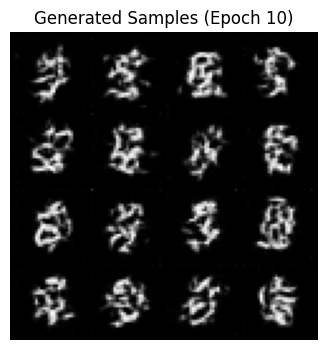

Epoch [11/100] - Loss: 39.8766
Epoch [12/100] - Loss: 39.5151
Epoch [13/100] - Loss: 39.1909
Epoch [14/100] - Loss: 38.9189
Epoch [15/100] - Loss: 38.8090
Epoch [16/100] - Loss: 38.6163
Epoch [17/100] - Loss: 38.4029
Epoch [18/100] - Loss: 38.2148
Epoch [19/100] - Loss: 38.0860
Epoch [20/100] - Loss: 37.9946


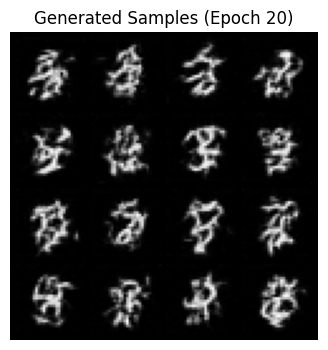

Epoch [21/100] - Loss: 37.8928
Epoch [22/100] - Loss: 37.8177
Epoch [23/100] - Loss: 37.6644
Epoch [24/100] - Loss: 37.5084
Epoch [25/100] - Loss: 37.4696
Epoch [26/100] - Loss: 37.4122
Epoch [27/100] - Loss: 37.4311
Epoch [28/100] - Loss: 37.2036
Epoch [29/100] - Loss: 37.1465
Epoch [30/100] - Loss: 37.0554


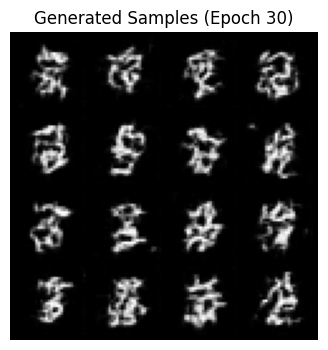

Epoch [31/100] - Loss: 37.0191
Epoch [32/100] - Loss: 36.9357
Epoch [33/100] - Loss: 36.8006
Epoch [34/100] - Loss: 36.8248
Epoch [35/100] - Loss: 36.6584
Epoch [36/100] - Loss: 36.6372
Epoch [37/100] - Loss: 36.5699
Epoch [38/100] - Loss: 36.6116
Epoch [39/100] - Loss: 36.4678
Epoch [40/100] - Loss: 36.3850


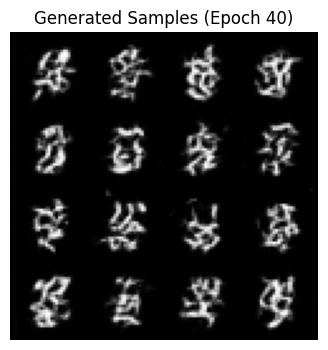

Epoch [41/100] - Loss: 36.4537
Epoch [42/100] - Loss: 36.3385
Epoch [43/100] - Loss: 36.3089
Epoch [44/100] - Loss: 36.2764
Epoch [45/100] - Loss: 36.1632
Epoch [46/100] - Loss: 36.1028
Epoch [47/100] - Loss: 36.1503
Epoch [48/100] - Loss: 36.0280
Epoch [49/100] - Loss: 35.9861
Epoch [50/100] - Loss: 35.9108


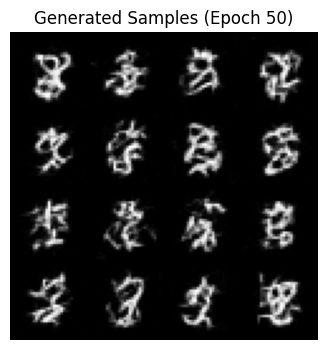

Epoch [51/100] - Loss: 35.8582
Epoch [52/100] - Loss: 35.9701
Epoch [53/100] - Loss: 35.9769
Epoch [54/100] - Loss: 35.7418
Epoch [55/100] - Loss: 35.7951
Epoch [56/100] - Loss: 35.7966
Epoch [57/100] - Loss: 35.6774
Epoch [58/100] - Loss: 35.7224
Epoch [59/100] - Loss: 35.7102
Epoch [60/100] - Loss: 35.6455


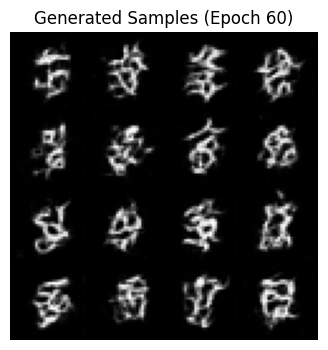

Epoch [61/100] - Loss: 35.6158
Epoch [62/100] - Loss: 35.4983
Epoch [63/100] - Loss: 35.5899
Epoch [64/100] - Loss: 35.5252
Epoch [65/100] - Loss: 35.5464
Epoch [66/100] - Loss: 35.4993
Epoch [67/100] - Loss: 35.4499
Epoch [68/100] - Loss: 35.4436
Epoch [69/100] - Loss: 35.4428
Epoch [70/100] - Loss: 35.4106


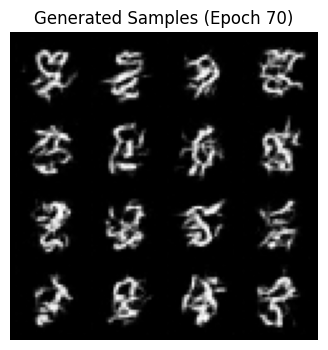

Epoch [71/100] - Loss: 35.4422
Epoch [72/100] - Loss: 35.3896
Epoch [73/100] - Loss: 35.3500
Epoch [74/100] - Loss: 35.2860
Epoch [75/100] - Loss: 35.3209
Epoch [76/100] - Loss: 35.2867
Epoch [77/100] - Loss: 35.3400
Epoch [78/100] - Loss: 35.2923
Epoch [79/100] - Loss: 35.2258
Epoch [80/100] - Loss: 35.2588


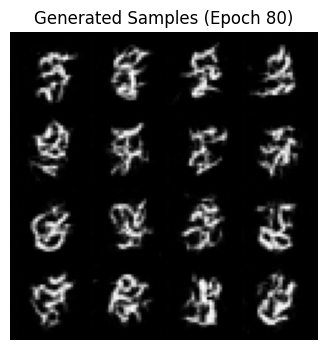

Epoch [81/100] - Loss: 35.1693
Epoch [82/100] - Loss: 35.1738
Epoch [83/100] - Loss: 35.1462
Epoch [84/100] - Loss: 35.1680
Epoch [85/100] - Loss: 35.1338
Epoch [86/100] - Loss: 35.1279
Epoch [87/100] - Loss: 35.0782
Epoch [88/100] - Loss: 35.1251
Epoch [89/100] - Loss: 35.0065
Epoch [90/100] - Loss: 35.0950


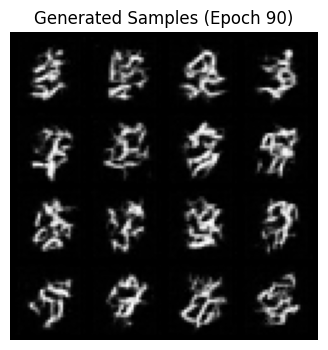

Epoch [91/100] - Loss: 35.0136
Epoch [92/100] - Loss: 34.9991
Epoch [93/100] - Loss: 35.0327
Epoch [94/100] - Loss: 35.0463
Epoch [95/100] - Loss: 34.9745
Epoch [96/100] - Loss: 35.0238
Epoch [97/100] - Loss: 34.9497
Epoch [98/100] - Loss: 34.8963
Epoch [99/100] - Loss: 34.9775
Epoch [100/100] - Loss: 34.8988


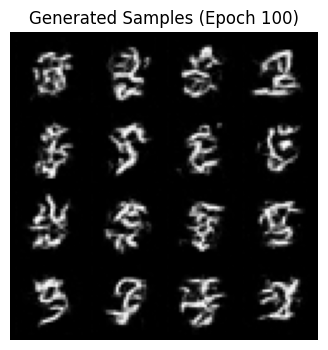

In [2]:
run_conv_noise_predictor(
    alpha=0.7,  # try 0.3, 0.5, 0.7, 0.9, etc.
    epochs=100,
    batch_size=128,
    lr=1e-3,
    show_every=10,
    hidden_channels=[32, 64, 32],  # try [64,128,64], etc.
)

As you can see, it kinda learns how to generate the digits, but not really. One step diffusion is not easy. That's why multi step diffusion models are more common. Also the problem is that corrupting $x_{0}$ with noise to make $x_{1}$, won't make it a normal Gaussian, unless $\alpha$ is 0. But if it's set to 0, then the decoder can't learn anything since there is no signal in $x_{1}$, but only noise.